<a href="https://colab.research.google.com/github/Bane-24/Bitcoin-Price-Forecasting/blob/main/Forecasted_Daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installing required libraries
!pip install cryptocmd
!pip install yfinance
!pip install keras-tuner

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from cryptocmd import CmcScraper
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
import keras_tuner
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D
from kerastuner.tuners import BayesianOptimization
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 5.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 10.4 MB/s eta 0:00:00


<ipython-input-1-e67f3defd4b2>:20: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import BayesianOptimization


In [2]:
# Scrape Bitcoin historical data
scraper = CmcScraper("BTC", "01-01-2014","31-03-2023")
bitcoin_df = scraper.get_dataframe()

# Scrape stock market data
stock_data = yf.download("SPY", start="2014-01-01", end="2023-03-31")
stock_df = stock_data["Adj Close"].to_frame().reset_index().rename(columns={"Adj Close": "stock_price", "Date": "Date"})

# Merge data and handle NA using interpolation
merged_df = bitcoin_df.merge(stock_df, on="Date", how="inner")
merged_df.set_index("Date", inplace=True)
merged_df.index = pd.to_datetime(merged_df.index)
merged_df.interpolate(method="time", inplace=True)

# Normalize features separately
scaler_btc = MinMaxScaler()
merged_df["Close"] = scaler_btc.fit_transform(merged_df[["Close"]])
scaler_stock = MinMaxScaler()
merged_df["stock_price"] = scaler_stock.fit_transform(merged_df[["stock_price"]])
scaler_volume = MinMaxScaler()
merged_df["Volume"] = scaler_volume.fit_transform(merged_df[["Volume"]])

[*********************100%***********************]  1 of 1 completed


In [3]:
merged_df = merged_df.sort_values(by = ['Date'])
merged_df.head()

,Open,High,Low,Close,Volume,Market Cap,stock_price
Date,,,,,,,
2014-01-02,773.440002,820.309998,767.210022,0.009264,0.000092,9.781074e+09,0.022988
2014-01-03,802.849976,834.150024,789.119995,0.009506,0.000090,9.980135e+09,0.022909
2014-01-06,936.049988,1017.119995,905.710022,0.011503,0.000226,1.162053e+10,0.021517
2014-01-07,946.489990,965.739990,802.000000,0.009258,0.000214,9.808300e+09,0.024459
2014-01-08,795.989990,870.679993,776.179993,0.009862,0.000194,1.031036e+10,0.024565


In [4]:
# Prepare data
def prepare_data(df, feature_columns, target_column, n_past, n_future):
    x_data, y_data = [], []
    for i in range(n_past, len(df) - n_future + 1):
        x_data.append(df[feature_columns].iloc[i - n_past:i].values)
        y_data.append(df[target_column].iloc[i:i + n_future].values)
    return np.array(x_data), np.array(y_data)

n_past = 30
n_future = 1
feature_columns = ["Close", "stock_price","Volume"]
target_column = "Close"
x_data, y_data = prepare_data(merged_df, feature_columns, target_column, n_past, n_future)

# Split into train and test sets
# Set the cutoff date
train_date = "2022-03-01"
# Calculate the index of the train_date
train_date_index = merged_df.index.get_loc(pd.Timestamp(train_date), method='nearest')

# Calculate the train_size based on the date
train_size = len(merged_df.loc[:train_date]) - n_past

x_train, x_test = x_data[:train_size], x_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

<ipython-input-4-03e0b99bd8bb>:19: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  train_date_index = merged_df.index.get_loc(pd.Timestamp(train_date), method='nearest')


In [5]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


x_train shape: (2025, 30, 3)
y_train shape: (2025, 1)
x_test shape: (272, 30, 3)
y_test shape: (272, 1)


In [6]:
# LSTM & Hyperparameter tuning
def create_model(learning_rate=0.001, dropout_rate=0.2, neurons=50):
  model = Sequential()
  model.add(LSTM(neurons, activation="tanh", input_shape=(n_past, len(feature_columns)), return_sequences=True))
  model.add(Dropout(dropout_rate))
  model.add(LSTM(neurons, activation="tanh", return_sequences=False))
  model.add(Dropout(dropout_rate))
  model.add(Dense(n_future))
  optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
  model.compile(optimizer=optimizer, loss="mse")
  return model

model = KerasRegressor(build_fn=create_model, verbose=0)

param_dist = {
    'batch_size': [32, 64],
    'epochs': [10],
    'learning_rate': [0.01, 0.001],
    'dropout_rate': [0.2, 0.4],
    'neurons': [25, 50]
}

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


<ipython-input-6-0859ed03a41b>:13: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb359da8b50>,
                   n_jobs=-1,
                   param_distributions={'batch_size': [32, 64],
                                        'dropout_rate': [0.2, 0.4],
                                        'epochs': [10],
                                        'learning_rate': [0.01, 0.001],
                                        'neurons': [25, 50]},
                   random_state=42, verbose=2)

In [7]:
print("Best parameters: ", random_search.best_params_)
best_model = random_search.best_estimator_.model

Best parameters:  {'neurons': 50, 'learning_rate': 0.001, 'epochs': 10, 'dropout_rate': 0.2, 'batch_size': 64}


In [8]:
# Make predictions
y_pred = best_model.predict(x_test)

9/9 [==============================] - 1s 3ms/step


Mean Squared Error: 4553908.40
Mean Absolute Error: 1480.75
R2 Score: 0.93


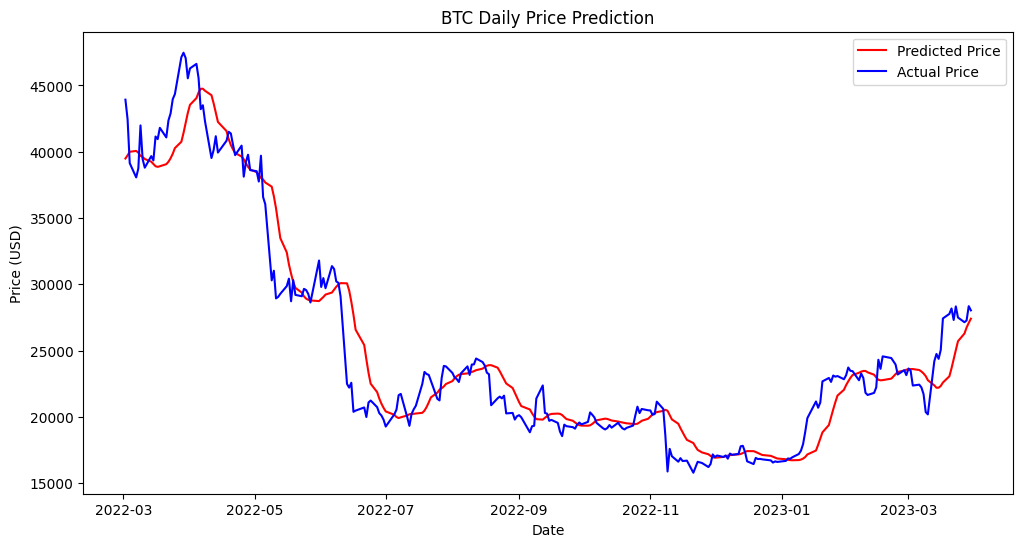

In [9]:
# Invert the scaling for predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
y_pred_actual = scaler_btc.inverse_transform(y_pred)
y_test_actual = scaler_btc.inverse_transform(y_test)
# Evaluate the model
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("Mean Squared Error: {:.2f}".format(mse))
print("Mean Absolute Error: {:.2f}".format(mae))
print("R2 Score: {:.2f}".format(r2))

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-len(y_pred_actual):], y_pred_actual, label="Predicted Price", color='r')
plt.plot(merged_df.index[-len(y_test_actual):], y_test_actual, label="Actual Price", color='b')
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc="best")
plt.title("BTC Daily Price Prediction")
plt.show()


1/1 [==============================] - 0s 23ms/step
[27654.24, 27821.904, 27931.04, 27997.746, 28032.791]


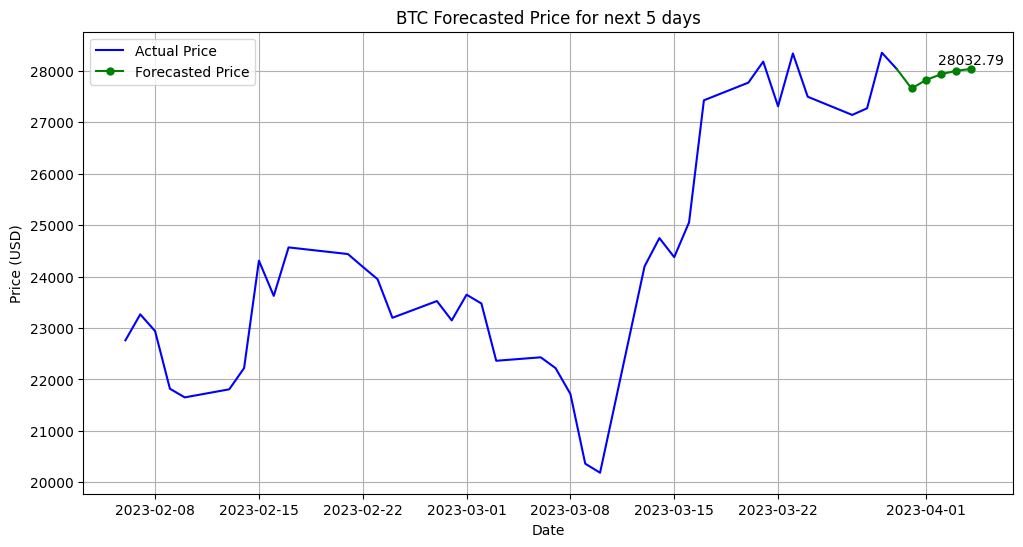

In [13]:
# Create dataframes for actual prices with dates as their index
actual_price_df = pd.DataFrame(scaler_btc.inverse_transform(merged_df[["Close"]]), index=merged_df.index, columns=["Actual Price"])

# Forecast for the next 5 days
x_forecast = merged_df[feature_columns].values[-n_past:]
forecasted_prices = []
forecasted_dates = []
for i in range(5):
    x_forecast = x_forecast.reshape((1, n_past, len(feature_columns)))
    y_forecast = best_model.predict(x_forecast)
    forecasted_price_actual = scaler_btc.inverse_transform(y_forecast)
    forecasted_prices.append(forecasted_price_actual[0][0])
    next_day = merged_df.index[-1] + pd.Timedelta(days=i+1)
    forecasted_dates.append(next_day)
    new_row = np.array([y_forecast[0][0], x_forecast[0][-1][1], x_forecast[0][-1][2]])
    x_forecast = np.append(x_forecast, new_row)
    x_forecast = x_forecast[-n_past * len(feature_columns):].reshape((n_past, len(feature_columns)))
print(forecasted_prices)
# Add the forecasted prices to a new dataframe
forecasted_price_df = pd.DataFrame(forecasted_prices, index=forecasted_dates, columns=["Forecasted Price"])

# Limit the data to last two months
last_two_months = forecasted_price_df.index[-1] - pd.DateOffset(months=2)
actual_price_df_last_two_months = actual_price_df[last_two_months:]
forecasted_price_df_last_two_months = forecasted_price_df[last_two_months:]

# Visualize the last two months of actual vs forecasted data
plt.figure(figsize=(12, 6))
plt.plot(actual_price_df_last_two_months.index, actual_price_df_last_two_months["Actual Price"], label="Actual Price", color='b')
plt.plot(forecasted_price_df_last_two_months.index, forecasted_price_df_last_two_months["Forecasted Price"], label="Forecasted Price", color='g', marker='o', markersize=5)

# Joining the forecasted line with the actual prices
last_actual_price = actual_price_df_last_two_months["Actual Price"].iloc[-1]
first_forecasted_price = forecasted_price_df_last_two_months["Forecasted Price"].iloc[0]
plt.plot([actual_price_df_last_two_months.index[-1], forecasted_price_df_last_two_months.index[0]], [last_actual_price, first_forecasted_price], color='g')

# Annotate last forecasted value
last_forecasted_price = forecasted_price_df_last_two_months["Forecasted Price"].iloc[-1]
last_forecasted_date = forecasted_price_df_last_two_months.index[-1]
plt.annotate(f'{last_forecasted_price:.2f}', (last_forecasted_date, last_forecasted_price), textcoords="offset points", xytext=(0,3), ha='center')

plt.grid()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend(loc="best")
plt.title("BTC Forecasted Price for next 5 days")
plt.show()